In [1]:
# if we apply normalize_image_signed before matrix multiplication
# this reproduces "gross features" of softmaxing rows of the left matrix
# and columns of the right matrix before matrix multiplication,
# but this does not reproduce fine-grained features

# joint work with github user 'nekel'

import LinearAlgebra: transpose, norm

function normalize_image(im)
    im_res = im .- minimum(im)
    return (1/maximum(im_res))*im_res
end

function normalize_image_signed(img)
    img1 = img .- minimum(img)
    img2 = (2/maximum(img1))*img1
    return img2 .- 1
end

normalize_image_signed (generic function with 1 method)

In [2]:
import ImageView: imshow
import Images: Gray
import TestImages: testimage
mandrill = 1*Gray.(testimage("mandrill"))
matrix_mandrill = convert(Matrix{Float32}, mandrill)
typeof(matrix_mandrill)

Matrix{Float32} (alias for Array{Float32, 2})

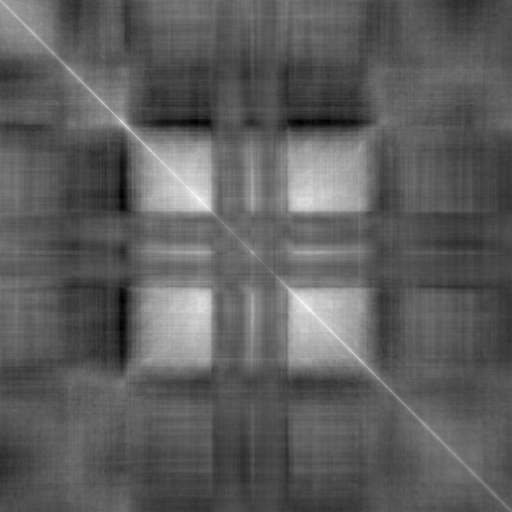

In [3]:
s_mm = normalize_image_signed(matrix_mandrill)
Gray.(normalize_image(transpose(s_mm)*s_mm))

In [4]:
jetplane = 1*Gray.(testimage("jetplane"))
matrix_jetplane = convert(Matrix{Float32}, jetplane)
typeof(matrix_jetplane)

Matrix{Float32} (alias for Array{Float32, 2})

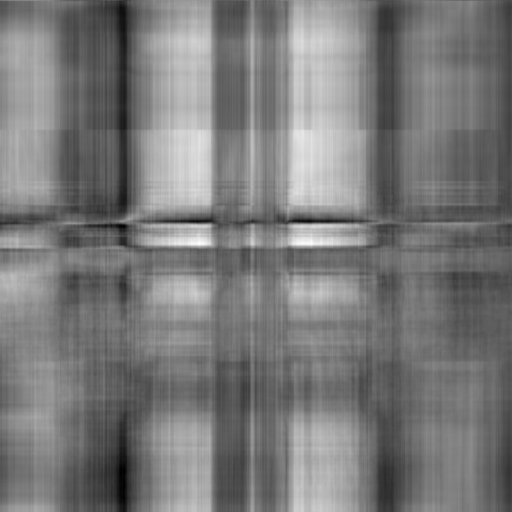

In [5]:
s_mj = normalize_image_signed(matrix_jetplane)
Gray.(normalize_image(s_mj*s_mm))

In [6]:
function warp3(x, y, p) # 0:31
    knob = p[:knob]
    clip(n, nsize) = max(min(nsize, n), 1)
    (xnew, ynew) =
        (clip(x + 10 * ((knob - 16) / 16) * sin(y/4), p[:xsize]), y)
    xnew, ynew
end

function apply_warp(warp, im, p)
    (xsize, ysize) = size(im)
    p[:xsize] = xsize
    p[:ysize] = ysize
    function linear_interpolation(x_y)
        # a rough draft, this can be improved; works on im
        x = x_y[1]
        y = x_y[2]
        dx=mod(x,1)
        dy=mod(y,1)
        x_left = floor(Int,x)
        y_left = floor(Int,y)
        x_right = min(x_left + 1, xsize)
        y_right = min(y_left + 1, ysize)
        im[x_left,y_left]*(1-dx)*(1-dy) + im[x_left,y_right]*(1-dx)*dy + im[x_right,y_left]*dx*(1-dy) + im[x_right, y_right]*dx*dy
    end
    [linear_interpolation(warp(x,y,p)) for x in 1:xsize, y in 1:ysize]
end

apply_warp (generic function with 1 method)

In [7]:
pars = Dict(:knob=>0, :dummy=>0.0)
# at least one of the above should be float and not integer, so that the dictionary type is
# Dict{Symbol, Real}  and not Dict{Symbol, Int64}

Dict{Symbol, Real} with 2 entries:
  :dummy => 0.0
  :knob  => 0

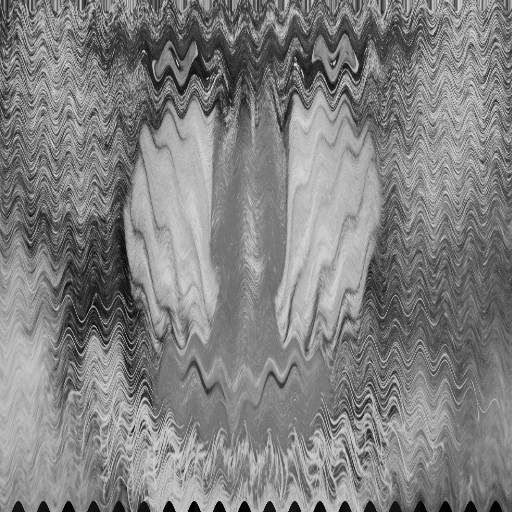

In [9]:
m_warped = apply_warp(warp3, matrix_mandrill, pars)
Gray.(m_warped)

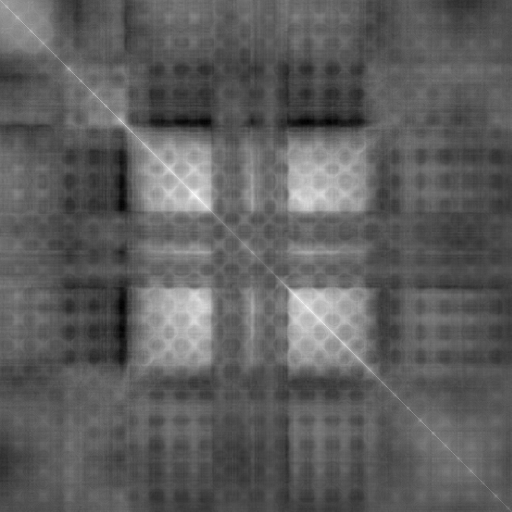

In [10]:
s_mm = normalize_image_signed(m_warped)
Gray.(normalize_image(transpose(s_mm)*s_mm))

In [12]:
norm_columns(f, x) = f.(x) ./ sum(f.(x), dims=1)

norm_rows(f, x) = f.(x) ./ sum(f.(x), dims=2)

norm_rows (generic function with 1 method)

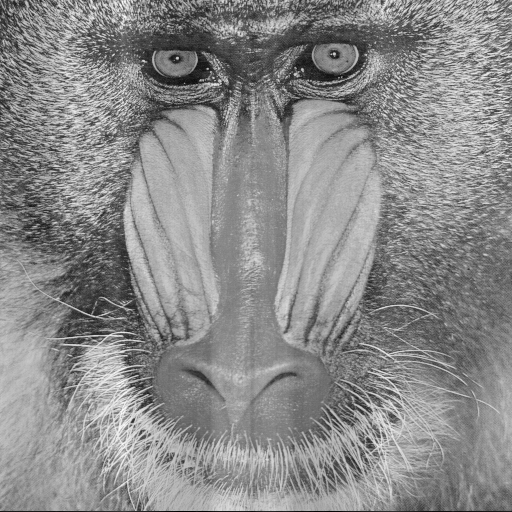

In [14]:
nc_m = normalize_image(norm_columns(x -> x+1, matrix_mandrill))
Gray.(nc_m)

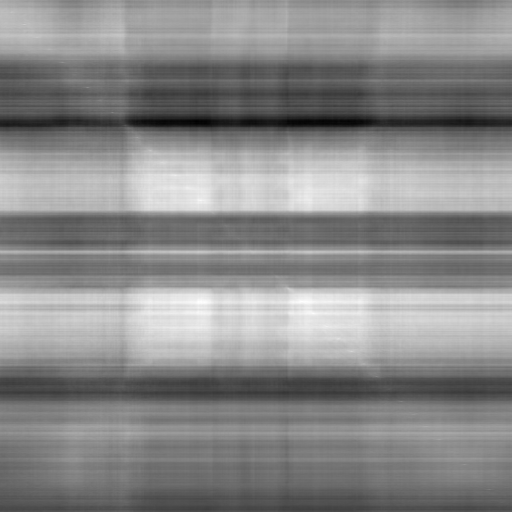

In [15]:
Gray.(normalize_image(transpose(s_mm)*nc_m))

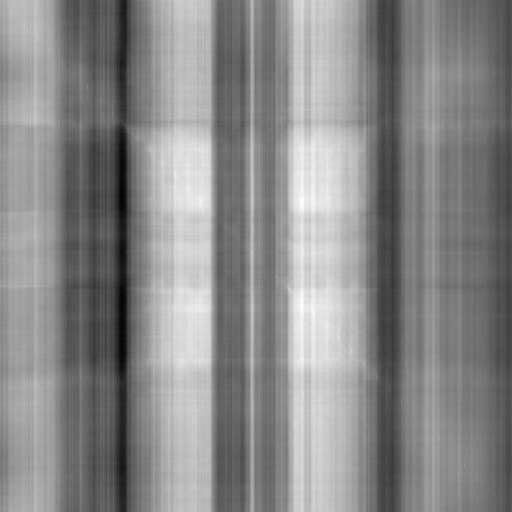

In [16]:
Gray.(normalize_image(transpose(nc_m)*s_mm))

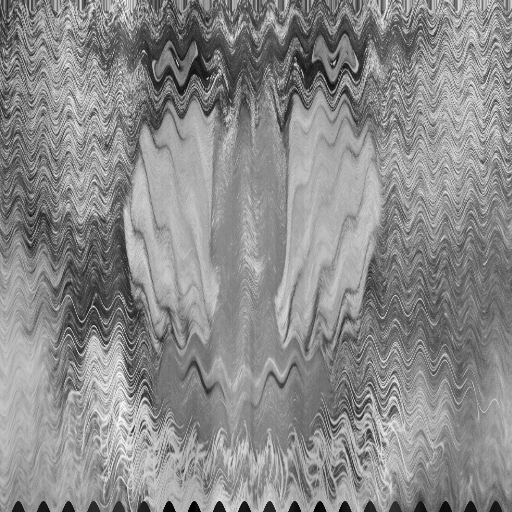

In [17]:
nc_m_warped = normalize_image(norm_columns(x -> x+1, m_warped))
Gray.(nc_m_warped)

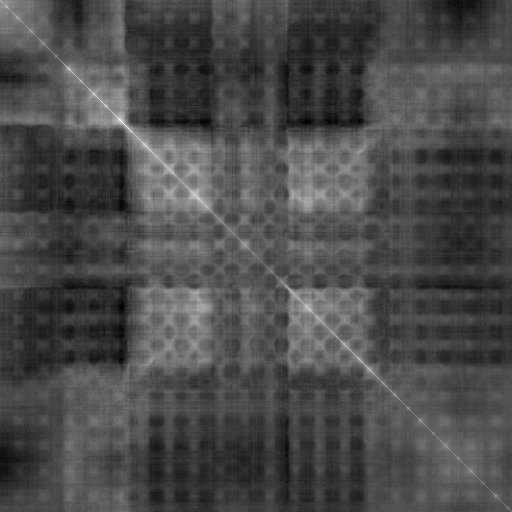

In [18]:
Gray.(normalize_image(transpose(nc_m_warped)*nc_m_warped))

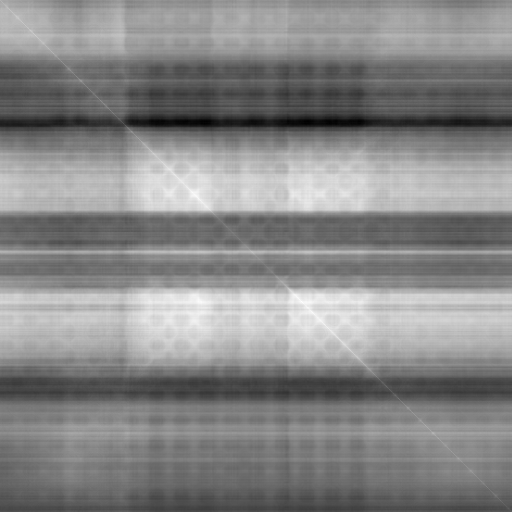

In [19]:
Gray.(normalize_image(transpose(m_warped)*nc_m_warped))

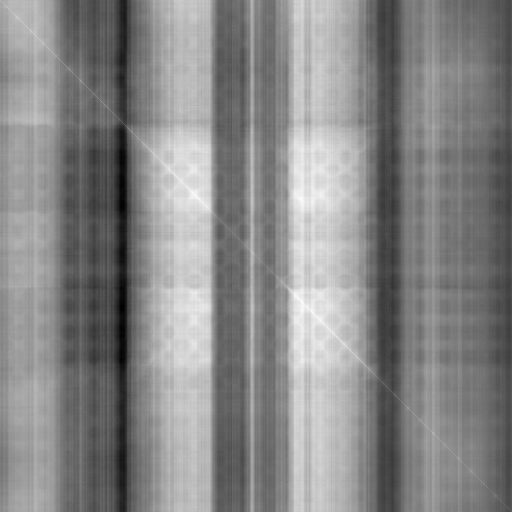

In [20]:
# experiment with mixing signed normalization and softmax normalization produces weak results
# (the hope was that it would be at least as good as signed normalization on both sides)
Gray.(normalize_image(transpose(nc_m_warped)*m_warped))

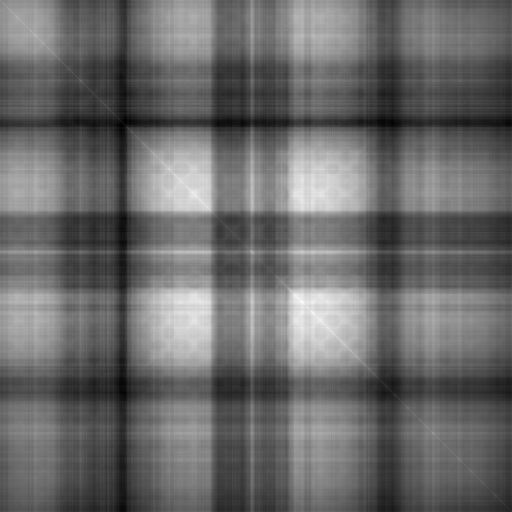

In [21]:
# the baseline we are comparing with is as follows
Gray.(normalize_image(transpose(m_warped)*m_warped))

In [22]:
# so we are a bit above that baseline